In [2]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from langdetect import detect,LangDetectException
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import LatentDirichletAllocation as LDA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
profs = pd.read_csv("Rate My Professors Reviews - Updated.csv")

In [4]:
np.random.seed(2022)

In [5]:
# Split dataset into two
train, test = train_test_split(profs, test_size=0.25, random_state=2022)

In [6]:
# Prepare dataset
# Keep only the variables that will be used for modelling
train = train[['Quality', 'Difficulty', 'Comment']]

In [7]:
# Rename variables
train = train.rename(columns={'Quality': 'rating', 'Difficulty': 'difficulty', 'Comment': 'comment'})

In [8]:
# Remove non-English reviews
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

train['language'] = train['comment'].apply(lambda x: detect_language(x) if isinstance(x, str) and x.strip() else 'unknown')
train = train[train['language'] == 'en']
train = train.drop(columns=['language'])

In [9]:
# Convert to lowercase, remove punctuation and special characters, remove stop words
train['comment'] = train['comment'].str.lower()
train['comment'] = train['comment'].str.replace('[^\w\s]', '', regex=True)

In [10]:
# Tokenize and remove stopwords
from nltk.corpus import stopwords
# Tokenize and remove stopwords
stop = stopwords.words('english')
train['comment'] = train['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]) if isinstance(x, str) else '')

In [11]:
# Remove rows with NaN values in 'rating'
train = train.dropna(subset=['rating'])

In [12]:
# Convert text to bag of words format
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train['comment'])

In [13]:
# Perform sLDA
num_topics = 8
lda = LDA(n_components=num_topics, random_state=2022)
lda.fit(X)

LatentDirichletAllocation(n_components=8, random_state=2022)

In [14]:
# Extract top words for each of the topics
def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.append(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return top_words

top_words = get_top_words(lda, vectorizer.get_feature_names_out(), 5)
print("Top words for each topic:\n", top_words)

Top words for each topic:
 ['prof, good, doesnt, know, class', 'class, good, prof, lectures, hard', 'class, professor, lectures, hes, knows', 'best, class, prof, ever, one', 'hes, easy, class, prof, hard', 'class, students, one, take, time', 'class, prof, easy, lectures, notes', 'prof, really, class, students, hes']


In [15]:
# Create dataframe for topics
topics_df = pd.DataFrame(top_words, columns=['topics'])

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_12324/1012015818.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=topics_df, x='topics', y='Estimate', join=False)


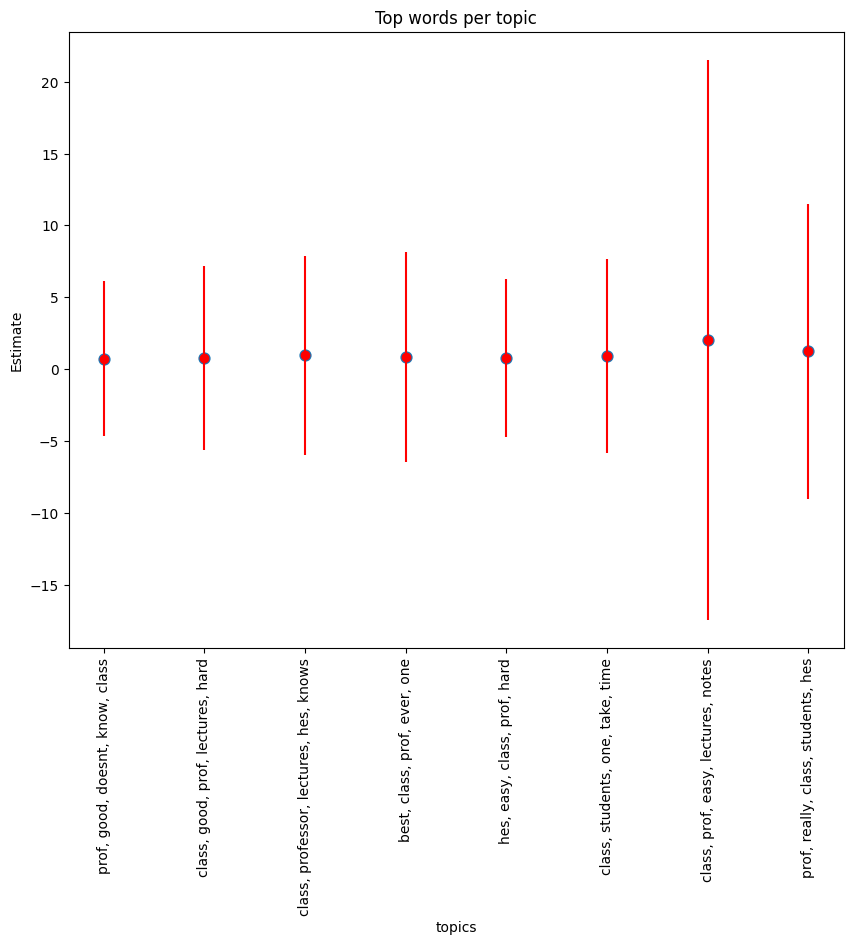

In [16]:
# Visualize top words per topic
topics_df['Estimate'] = lda.components_.mean(axis=1)
topics_df['Std_Error'] = lda.components_.std(axis=1)

plt.figure(figsize=(10, 8))
sns.pointplot(data=topics_df, x='topics', y='Estimate', join=False)
plt.errorbar(x=topics_df['topics'], y=topics_df['Estimate'], yerr=1.96 * topics_df['Std_Error'], fmt='o', color='r')
plt.xticks(rotation=90)
plt.title('Top words per topic')
plt.show()

In [17]:
X_topics = lda.transform(X)
df = pd.DataFrame(X_topics, columns=[f'topic{i+1}' for i in range(num_topics)])
df['rating'] = train['rating']
df = df.dropna(subset=['rating'])  # Ensure there are no NaN values in 'rating'

In [18]:
# Linear regression model
lmod = LinearRegression().fit(df.drop(columns='rating'), df['rating'])

In [19]:
# Add another explanatory variable to the model
df['difficulty'] = train['difficulty']
df = df.dropna(subset=['difficulty'])  # Ensure there are no NaN values in 'difficulty'
lmod_with_difficulty = LinearRegression().fit(df.drop(columns='rating'), df['rating'])

In [20]:
# Prediction on unseen data
test = test[['Quality', 'Difficulty', 'Comment']]
test = test.rename(columns={'Quality': 'rating', 'Difficulty': 'difficulty', 'Comment': 'comment'})

In [21]:
test['language'] = test['comment'].apply(lambda x: detect_language(x) if isinstance(x, str) and x.strip() else 'unknown')
test = test[test['language'] == 'en']
test = test.drop(columns=['language'])

test['comment'] = test['comment'].str.lower()
test['comment'] = test['comment'].str.replace('[^\w\s]', '', regex=True)
test['comment'] = test['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]) if isinstance(x, str) else '')

# Remove rows with NaN values in 'rating'
test = test.dropna(subset=['rating'])

In [22]:
X_test = vectorizer.transform(test['comment'])

# Predict using first model (no explanatory variables aside from topics)
X_test_topics = lda.transform(X_test)
yhat = lmod.predict(X_test_topics)

/Users/ritutoshniwal/Code/news_analysis/env/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [23]:
# Predict using second model (difficulty variable as an explanatory variable in addition to topics)
df_test = pd.DataFrame(X_test_topics, columns=[f'topic{i+1}' for i in range(num_topics)])
df_test['rating'] = test['rating']
df_test['difficulty'] = test['difficulty']
df_test = df_test.dropna(subset=['rating', 'difficulty'])  # Ensure no NaN values in 'rating' and 'difficulty'
yhat_with_difficulty = lmod_with_difficulty.predict(df_test.drop(columns='rating'))

In [26]:
import re

def preprocess_review(review):
    # Convert to lowercase
    review = review.lower()
    # Remove punctuation and special characters
    review = re.sub(r'[^\w\s]', '', review)
    # Tokenize and remove stopwords
    review = ' '.join([word for word in review.split() if word not in stop])
    return review

def predict_rating(review, difficulty=None):
    # Preprocess the review
    review = preprocess_review(review)
    # Convert the review to the bag of words format
    review_vectorized = vectorizer.transform([review])
    # Get the topic distribution from the LDA model
    review_topics = lda.transform(review_vectorized)
    
    # Create a dataframe with the topic distribution
    df_review = pd.DataFrame(review_topics, columns=[f'topic{i+1}' for i in range(num_topics)])
    
    if difficulty is not None:
        # Add difficulty to the dataframe
        df_review['difficulty'] = difficulty
        # Predict the rating using the model with difficulty
        predicted_rating = lmod_with_difficulty.predict(df_review)
    else:
        # Predict the rating using the model without difficulty
        predicted_rating = lmod.predict(df_review)
    
    return predicted_rating[0]

# Example usage
review = "The professor explained the concepts very badly and was not available to help students."
difficulty = 3  # Optional, you can set this to None if you don't want to use difficulty

predicted_rating = predict_rating(review, difficulty)
print(f"Predicted rating for the review: {predicted_rating:.2f}")

Predicted rating for the review: 3.57
